In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pydot
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Data preprocessing 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

## Add Noise

In [4]:
noise_factor=10

In [5]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0,scale=1.0,size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0,scale=1.0,size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)

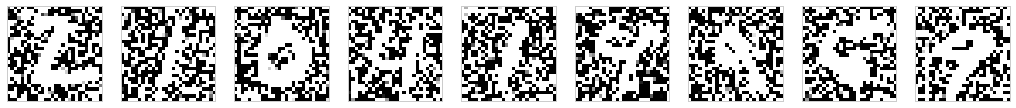

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
x_train = x_train_noisy
x_test = x_test_noisy

In [8]:
x_train_noisy = tf.expand_dims(x_train, axis=-1, name=None)
x_test_noisy = tf.expand_dims(x_test, axis=-1, name=None)

In [9]:
x_train_noisy.shape, x_test_noisy.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [10]:
y_train = keras.utils.to_categorical(y_train, 10, dtype='uint8')
y_test = keras.utils.to_categorical(y_test, 10, dtype='uint8')

# Model Designing

In [11]:
input_shape = (28, 28, 1)
classes = 10
epochs = 10
batch_size = 128

## Add AutoEncoder to Denoise the Data

In [41]:
input_img = layers.Input(shape=input_shape)  
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

In [42]:
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [43]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
his = autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128)

Epoch 1/10
469/469 [==============================] - 92s 195ms/step - loss: 0.6930
Epoch 2/10
469/469 [==============================] - 98s 208ms/step - loss: 0.6840
Epoch 3/10
469/469 [==============================] - 101s 216ms/step - loss: 0.6763
Epoch 4/10
469/469 [==============================] - 103s 220ms/step - loss: 0.6710
Epoch 5/10
469/469 [==============================] - 103s 219ms/step - loss: 0.6683
Epoch 6/10
469/469 [==============================] - 107s 228ms/step - loss: 0.6665
Epoch 7/10
469/469 [==============================] - 107s 227ms/step - loss: 0.6649
Epoch 8/10
469/469 [==============================] - 103s 220ms/step - loss: 0.6632
Epoch 9/10
469/469 [==============================] - 104s 221ms/step - loss: 0.6614
Epoch 10/10
317/469 [===================>..........] - ETA: 33s - loss: 0.6598

In [16]:
denoised_x_train = autoencoder.predict(x_train_noisy)
denoised_x_test =autoencoder.predict(x_test_noisy)

In [17]:
autoencoder.save('auto_encoder_10epoch_adadelta.h5')

In [35]:
his.history

{'loss': [0.5277148485183716,
  0.41831687092781067,
  0.37885865569114685,
  0.35467275977134705,
  0.3362187445163727,
  0.32288500666618347,
  0.3127610385417938,
  0.3043263554573059,
  0.2964690327644348,
  0.2887203097343445]}

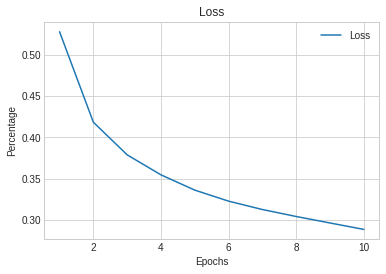

In [36]:
fig = plt.figure()
ax = plt.axes()
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.title('Loss')

x = np.arange(1,10+1)
loss = his.history.get('loss')

plt.plot(x, loss, label='Loss')

plt.legend()
plt.show()

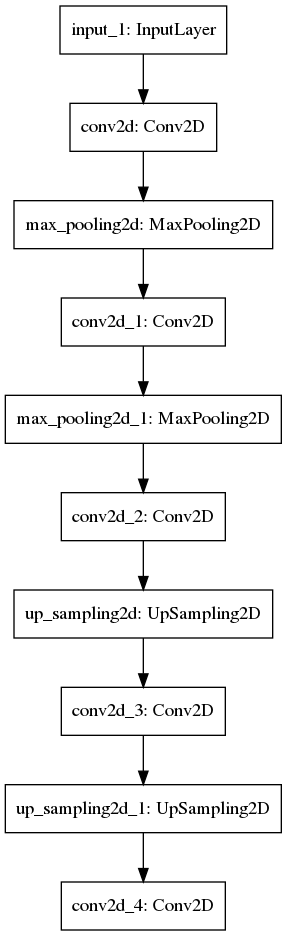

In [18]:
tf.keras.utils.plot_model(
    autoencoder, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

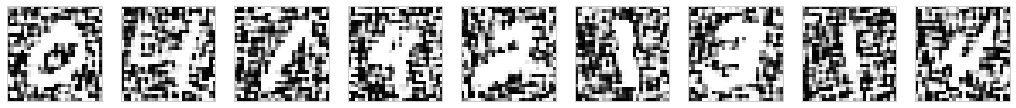

In [19]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(denoised_x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

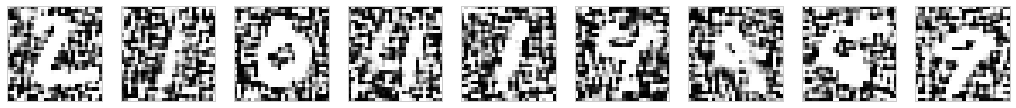

In [20]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(denoised_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2-Conv

In [21]:
model = keras.Sequential()

In [22]:
model.add(keras.Input(shape=input_shape))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.9))
model.add(layers.Dense(classes, activation="softmax"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                3

In [24]:
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [25]:
history = model.fit(denoised_x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, 
                    use_multiprocessing=True)

Epoch 1/10
422/422 [==============================] - 31s 73ms/step - loss: 1.1639 - accuracy: 0.6047 - val_loss: 0.3633 - val_accuracy: 0.9032
Epoch 2/10
422/422 [==============================] - 31s 74ms/step - loss: 0.6421 - accuracy: 0.7899 - val_loss: 0.2841 - val_accuracy: 0.9213
Epoch 3/10
422/422 [==============================] - 31s 75ms/step - loss: 0.5792 - accuracy: 0.8121 - val_loss: 0.2549 - val_accuracy: 0.9305
Epoch 4/10
422/422 [==============================] - 33s 79ms/step - loss: 0.5528 - accuracy: 0.8189 - val_loss: 0.2405 - val_accuracy: 0.9318
Epoch 5/10
422/422 [==============================] - 35s 83ms/step - loss: 0.5350 - accuracy: 0.8261 - val_loss: 0.2282 - val_accuracy: 0.9383
Epoch 6/10
422/422 [==============================] - 33s 79ms/step - loss: 0.5133 - accuracy: 0.8338 - val_loss: 0.2125 - val_accuracy: 0.9397
Epoch 7/10
422/422 [==============================] - 33s 79ms/step - loss: 0.5073 - accuracy: 0.8363 - val_loss: 0.2156 - val_accuracy:

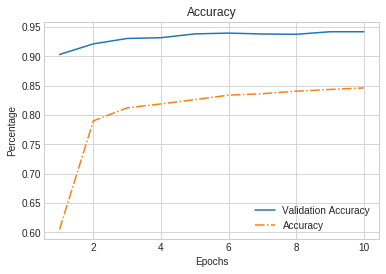

In [27]:
fig = plt.figure()
ax = plt.axes()
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.title('Accuracy')

x = np.arange(1,epochs+1)
val_accuracy = history.history.get('val_accuracy')
accuracy = history.history.get('accuracy')

plt.plot(x, val_accuracy, label='Validation Accuracy')
plt.plot(x, accuracy, linestyle='dashdot', label='Accuracy')

plt.legend()
plt.show()

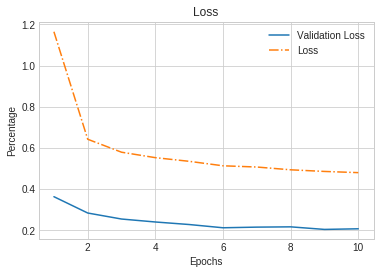

In [28]:
fig = plt.figure()
ax = plt.axes()
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.title('Loss')

x = np.arange(1,epochs+1)
val_loss = history.history.get('val_loss')
loss = history.history.get('loss')

plt.plot(x, val_loss, label='Validation Loss')
plt.plot(x, loss, linestyle='dashdot', label='Loss')

plt.legend()
plt.show()

# Evaluation

In [29]:
score = model.evaluate(denoised_x_test, y_test, verbose=0)
print('Accuracy - %s%%' %round(score[1] * 100, 4))
print('Loss - %s%%' % round(score[0] * 100, 4))

Accuracy - 93.15%
Loss - 22.9866%
